---

# Implementation of Neural Network on the MNIST Data Set

By: Laura Moses

---

## The MNIST Data Set
The MNIST data set consists of $70,000$ images of hand written digits, $60,000$ of which are typically used as labeled training examples, where the other $10,000$ are used for testing your learning model on. 

<img src="MnistExamples.png" width="50%">


To access this data set, as well as view the data as an image, we will need the following packages:
* MLDatasets [documentation](https://github.com/JuliaML/MLDatasets.jl)
* Images, Testimages, ImageMagicO [documentation](https://juliaimages.org/latest/)

---

In [5]:
using MLDatasets, Plots, Images, TestImages

"
train_x, train_y = Fashion_MNIST.traindata()
test_x,  test_y  = Fashion_MNIST.testdata()
"

train_x, train_y = MNIST.traindata()
test_x,  test_y  = MNIST.testdata();

---

The  data structures train_x and test_x are stored as 3 dimensional tensors.

<img src="order-3-tensor.png" width="50%">

---

In [4]:
# Show the dimensions of the train_x tensor.
size(train_x)

(28, 28, 60000)

---

Each image in the is comprised of a $28\times 28$ grey scaled grid of pixel values. These values are floating point numbers in the interval $(0,1)$, where darker pixels will have values closer to $1$ and lighter pixels will have values closer to $0$. The following image represents one such example.

<img src="MNIST-Matrix.png" width="75%">

---

In [7]:
# Verify the dimensions of the training vector. This should match the depth of out training 
# tensor. 
size(train_y)

(60000,)

In [6]:
# Verify the the shape of the elements in the tensor slices.
train_x[:,:,1]

28×28 Array{N0f8,2} with eltype Normed{UInt8,8}:
 0.0  0.0  0.0  0.0  0.0  0.0    0.0    …  0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.0    0.0    0.0    0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.0    0.216  0.533  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0    …  0.0    0.675  0.992  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.071  0.886  0.992  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.0       0.671  0.992  0.992  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.118     0.859  0.992  0.831  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.141     0.992  0.992  0.529  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.369  …  0.992  0.992  0.518  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0    0.604     0.992  0.957  0.063  0.0  0.0  0.0
 0.0  0.0  0.0 

The first image in our train data is labeled 5

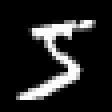

In [11]:
print("The first image in our train data is labeled ", train_y[1])
colorview(Gray, train_x[:, :, 1]')

---

Each of these training features is a matrix, but our neuron network is going to take in a vector, so we need to flatter or reshape our matrix into a vector. 

---

In [13]:
# Flatten the train matrix input data into a vector
X = []   # Flattened 784 column vectors
Y = []   # One-hot encoding label vectors 
for i = 1:60000 # 60000 in train set
    push!(X, reshape(train_x[:, :, i], 784))
    y = zeros(10)
    y[train_y[i] + 1] = 1.0
    push!(Y,y)
end

train_data = [x for x in zip(X, Y)];

# Flatten the test matrix input data into a vector
X = []   # Flattened 784 column vectors
Y = []   # One-hot encoding label vectors 
for i = 1:10000 # 10000 in test set
    push!(X, reshape(test_x[:, :, i], 784))
    y = zeros(10)
    y[test_y[i] + 1] = 1.0
    push!(Y,y)
end

test_data = [x for x in zip(X, Y)];

## Building the Network Architecture

For our purposes, we will build a multilayered perceptron with $L$ layers, $784$ input neurons, $L-2$ hidden layers of arbitrary size, and $10$ neurons in the output layer. 

For our activation function, we will use the sigmoid function:
* Sigmoid Function
$$
\sigma(s) = \frac{1}{1+e^{-s}}.
$$

![Multi-layer Perceptron](multilayerPerceptron.jpg)

For $l = 2, \dots, L$, each layer $l$ in our network will have two phases, the preactivation phase$$z^l = W^la^{l-1} + b^l,$$and postactivation phase$$a^l = \sigma(z^l).$$The preactivation phase consists of a weighted linear combination of postactivation values in the previous layer. The postactivation values consists of passing the preactivation value through an activation function elementwise. Note $a^1 = x^{(i)}$, where $x^{(i)}$ is the current input feature vector of our network. 

For a given training instance $(x^{(i)}, y^{(i)}),$ we will use the Mean Square Error cost for our cost function: 

$$
C = C(W, b) = \frac{1}{2}\sum_{k=1}^n(a_k^L - y_k^{(i)})^2.
$$

Here $n=10$ is the size of our output layer. 

In [17]:
# Define the activation function and its derivative
## Define the sigmoid function
σ(x) = 1.0/(1.0 + exp(-x))

## Define the derivative of the sigmoid function
dσ(x) = σ(x)*(1.0 - σ(x))

# Define a neural network type 
mutable struct neural_network
    W
    b
end

function create_network(input_layer_size, hidden_layer_sizes, output_layer_size)
    W = [[0.0], randn(hidden_layer_sizes[1], input_layer_size)]
    b = [[0.0], randn(hidden_layer_sizes[1])]
    
    for i = 2:length(hidden_layer_sizes)
        push!(W, randn(hidden_layer_sizes[i], hidden_layer_sizes[i-1]))
        push!(b, randn(hidden_layer_sizes[i]))
    end
    
    push!(W, randn(output_layer_size, hidden_layer_sizes[end]))
    push!(b, randn(output_layer_size))
    
    return neural_network(W, b)
end

create_network (generic function with 1 method)

In [18]:
# Test the function above
NN = create_network(784, [100, 100, 100], 10)

neural_network(Array{Float64,N} where N[[0.0], [-1.1123802231260982 0.4347725954129352 … 0.5792170340175226 1.8753654818790204; -1.556446840553762 -1.0248230775671312 … 2.231289982641541 -0.6868229370654111; … ; -0.9083383833664456 0.23932511516814717 … -0.14407474590877406 1.4423775396585072; -0.9030656337743164 -0.8327125578275809 … 0.7420202892845317 0.013651040127985906], [-1.911005668932279 -0.000725052374097794 … -0.35869914294390765 -0.7243418795047197; 0.008566649427737395 -3.619080458333703 … -0.9008692463984522 -0.8649929531841795; … ; 1.5270079866767867 0.3900331284876632 … 0.0030500050823235093 0.08751273803453183; 0.04593789558564245 0.1290524274252913 … -0.7229890622053557 0.3704568522335142], [-0.1348873133611347 -0.5472035346369668 … 1.474310759104941 -1.3485016217242505; 0.006873842993036479 -0.7092916632095694 … 0.5080543598239289 0.034257300901952815; … ; -1.295996156353902 0.31895029572872896 … -1.1990852096662263 -1.5310718953873315; -0.8784647440448083 -0.20846961

In [21]:
# Access elements of W (weights)
NN.W

5-element Array{Array{Float64,N} where N,1}:
 [0.0]
 [-1.1123802231260982 0.4347725954129352 … 0.5792170340175226 1.8753654818790204; -1.556446840553762 -1.0248230775671312 … 2.231289982641541 -0.6868229370654111; … ; -0.9083383833664456 0.23932511516814717 … -0.14407474590877406 1.4423775396585072; -0.9030656337743164 -0.8327125578275809 … 0.7420202892845317 0.013651040127985906]
 [-1.911005668932279 -0.000725052374097794 … -0.35869914294390765 -0.7243418795047197; 0.008566649427737395 -3.619080458333703 … -0.9008692463984522 -0.8649929531841795; … ; 1.5270079866767867 0.3900331284876632 … 0.0030500050823235093 0.08751273803453183; 0.04593789558564245 0.1290524274252913 … -0.7229890622053557 0.3704568522335142]
 [-0.1348873133611347 -0.5472035346369668 … 1.474310759104941 -1.3485016217242505; 0.006873842993036479 -0.7092916632095694 … 0.5080543598239289 0.034257300901952815; … ; -1.295996156353902 0.31895029572872896 … -1.1990852096662263 -1.5310718953873315; -0.8784647440448083 -0.20

In [19]:
# Access elements of b (biases)
NN.b

5-element Array{Array{Float64,1},1}:
 [0.0]
 [0.02512968049357752, -0.4716407569346034, 0.3900932805173733, 0.884556907565213, -0.5743191237973417, 0.5206699170666522, -0.1721097389537644, 0.14109020392937638, -0.736205604993175, 0.9074747324844741  …  -1.5629405643210401, 0.16163806040052964, 0.30484272515962463, -0.11154280717008574, -0.8991253752013845, -0.6546096844558811, 0.9497818989114215, 0.9692744614025341, -1.1509376804475144, -0.26395825675846163]
 [-0.8429930745330331, -0.4651130609730785, -1.1781890310913434, -0.7485218947986829, 0.1716544690963067, 0.8205663030082959, -0.34853528236222464, -1.704423383884232, 0.5862266926666723, 0.9901731104405919  …  0.38549091834312493, 1.4289093066592742, 1.1587820770684116, -0.29293475197561825, -0.40052283648488896, -0.8854296320300644, -1.0344738161458122, -0.012066307857479298, 1.5504543833180717, 1.484474399433517]
 [0.4243994534691331, 1.5792071961270162, 0.21739143631913624, -0.1901402349375886, 1.261044563351174, -0.35911316753

In [20]:
# To look at the dimensions of the network
for w in NN.W
    println(size(w))
    println("")
end

(1,)

(100, 784)

(100, 100)

(100, 100)

(10, 100)



In [35]:
# Define feedforward pass of the network 
function forward_pass(network, training_instance)
    Z = [[0.0]]
    A = [training_instance[1]]
    
    for i = 2:length(network.W) # number of layers
        push!(Z, network.W[i]*A[i-1] + network.b[i])
        push!(A, σ.(Z[i]))
    end
    
    return Z, A
end

# Define the predicted outcome of the network with a function
function predict(network, training_instance)
    Z, A = forward_pass(network, training_instance)
    return argmax(A[end])- 1 # the index of the highest value in A
end

# Define a function to test the accuracy of our predictions
function success_percentage(network, data_set)
   return string("The percentage of correctly classified images is: ", sum(predict(network, x) == argmax(x[2]) - 1 ? 1 : 0 for x in data_set)/length(data_set)*100.0, "%") 
end

success_percentage (generic function with 1 method)

In [36]:
# Test function above
success_percentage(NN, test_data)

"The percentage of correctly classified images is: 10.05%"

---

This means that without having trained our data yet, we are already at 10% accuracy. 

---

In [42]:
function error_deltas(network, training_instance)
    L = length(network.W) # number of layers
    Z, A = forward_pass(network, training_instance)
    δ = [ (A[end] - training_instance[2]).*dσ.(Z[end]) ]
        
    for i = L-1:-1:2
        pushfirst!(δ, (network.W[i+1]'*δ[1]).*dσ.(Z[i]))
    end
    
    pushfirst!(δ, [0.0])
    return A, δ
end

error_deltas (generic function with 1 method)

In [46]:
# Test function above
A_test, δ_test = error_deltas(NN, train_data[1])

(Array{Normed{UInt8,8},1}[[0.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8  …  0.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8, 0.0N0f8], [0.0N0f8, 1.0N0f8, 0.0N0f8, 0.651N0f8, 0.0N0f8, 0.0N0f8, 0.824N0f8, 0.016N0f8, 1.0N0f8, 0.004N0f8  …  0.0N0f8, 0.0N0f8, 0.0N0f8, 1.0N0f8, 0.067N0f8, 1.0N0f8, 0.004N0f8, 1.0N0f8, 0.0N0f8, 0.6N0f8], [0.0N0f8, 1.0N0f8, 0.988N0f8, 0.0N0f8, 0.0N0f8, 0.855N0f8, 0.059N0f8, 0.922N0f8, 0.082N0f8, 1.0N0f8  …  0.651N0f8, 0.0N0f8, 0.953N0f8, 1.0N0f8, 0.0N0f8, 0.008N0f8, 0.871N0f8, 0.133N0f8, 0.996N0f8, 0.129N0f8], [0.2N0f8, 0.0N0f8, 0.976N0f8, 0.0N0f8, 0.0N0f8, 1.0N0f8, 0.576N0f8, 0.314N0f8, 0.992N0f8, 0.271N0f8  …  0.0N0f8, 1.0N0f8, 0.0N0f8, 1.0N0f8, 1.0N0f8, 0.004N0f8, 0.094N0f8, 0.0N0f8, 0.008N0f8, 0.0N0f8], [0.835N0f8, 0.0N0f8, 0.0N0f8, 0.071N0f8, 0.992N0f8, 0.996N0f8, 0.51N0f8, 1.0N0f8, 0.898N0f8, 1.0N0f8]], [[0.0], [3.9257444568427374e-8, -4.7060021011353394e-8, 1.4201833340645675e-9,

In [47]:
# Verify output is a 10 dimension vector
δ_test[end] 

10-element Array{Float64,1}:
  0.11518278007731018
  0.0
  0.0
  0.004602164143018406
  0.006289850211743142
 -1.757150040346731e-5
  0.1274102825525214
  8.645521274577815e-5
  0.08199089954310082
  0.0002455885907050107

---

#### Now we need to write a function to make a mini batch and update

---

In [60]:
function make_random_mini_batch(mini_batch_size, data_set)
    k = rand(1:length(data_set) - mini_batch_size)
    return data_set[k:k + mini_batch_size]
end

function mini_batch_update!(network, mini_batch_size, data_set, α)
    
    mini_batch = make_random_mini_batch(mini_batch_size, data_set)
    L = length(network.W)
    
    A, δ = error_deltas(network, mini_batch[1])
    A_batch = []
    δ_batch = []
    push!(A_batch, A)
    push!(δ_batch, δ)
    
    for i = 2:mini_batch_size
        A, δ = error_deltas(network, mini_batch[i])
        push!(A_batch, A)
        push!(δ_batch, δ) 
    end
    
    # update weights and biases
    for l = L:-1:2
        network.W[l] -= (α/mini_batch_size)*sum([δ_batch[i][l]*A_batch[i][l-1]' for i = 1:mini_batch_size])
        network.b[l] -= (α/mini_batch_size)*sum([δ_batch[i][l] for i = 1:mini_batch_size])
    end
end;

---

#### Now it's time to train the data. The following two cells are run several times changing the batch size and learning level $\alpha$ until the desired success rate is reached.

---

In [136]:
# Training data
for _ = 1:60000
    mini_batch_update!(NN, 5, train_data, 0.1)
end

In [137]:
#Now, let's check our error rate on test_data
success_percentage(NN, test_data)

"The percentage of correctly classified images is: 96.02000000000001%"

---

#### Now that the data has been trained, to visualize we include the following functions and run the code cell that follows a few times to see how well our predictions are doing. 

---

In [78]:
# Fun ways to visualize images
## Training functions
function show_training_img(i)
    colorview(Gray, train_x[:,:,i]')
end

function show_train_example(network, i, training_data)
    println("Predicted Label: ", predict(network, training_data[i]))
    println("Actual Label: ", argmax(training_data[i][2]) - 1)
    show_training_img(i)
end

## Testing functions
function show_test_img(i)
    colorview(Gray, test_x[:,:,i]')
end

function show_test_example(network, i, testing_data)
    println("Predicted Label: ", predict(network, testing_data[i]))
    println("Actual Label: ", argmax(testing_data[i][2]) - 1)
    show_test_img(i)
end

show_test_example (generic function with 1 method)

Predicted Label: 9
Actual Label: 9


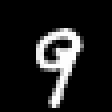

In [92]:
i = rand([x for x = 1:10000])
show_test_example(NN, i, test_data)

Predicted Label: 4
Actual Label: 4


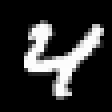

In [109]:
i = rand([x for x = 1:10000])
show_test_example(NN, i, test_data)

Predicted Label: 3
Actual Label: 3


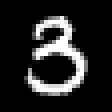

In [117]:
i = rand([x for x = 1:10000])
show_test_example(NN, i, test_data)

Predicted Label: 8
Actual Label: 8


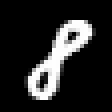

In [115]:
i = rand([x for x = 1:10000])
show_test_example(NN, i, test_data)

Predicted Label: 4
Actual Label: 6


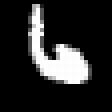

In [118]:
i = rand([x for x = 1:10000])
show_test_example(NN, i, test_data)

In [80]:
# Define the cost of a given output
MSE(a, y) = (1/2)*sum((a[i] - y[i])^2 for i = 1:size(a)[1])

# Define the total cost of a dataset with respect to weights and bias

function total_MSE(W, b, labeled_data)
    cost = 0.0
    for i = 1:60000
        Z, A = forward_pass(W, b, labeled_data[i])
        cost += MSE(σ.(A[size(W)[1]]), labeled_data[i][2])
    end
    return cost/60000
end

total_MSE (generic function with 1 method)

In [ ]:
total_MSE(NN.W[1], NN.b[1], test_data)